In [20]:
import glob
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from prettytable import PrettyTable
from tqdm import tqdm
from torchvision.models import squeezenet1_1, mobilenet_v3_small, mobilenet_v3_large, resnet50, densenet121
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import mobilenet_v3_small
from torchvision.transforms import v2
from tools.data import data_generator
from tools.fit import train, validate

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: add more transforms - RandomPerspective/ RandomRotation/ FiveCrop OR RandomCrop &OR RandomResizedCrop
train_transform = v2.Compose([v2.ToImage(), 
                              v2.ToDtype(torch.float32, scale=True)
                              #v2.RandomPerspective(),
                              #v2.RandomRotation(degrees=30),
                              #v2.FiveCrop(size=(48,48)),
                              #v2.Normalize()
                              ])

eval_transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

In [3]:
# --- LOAD DATA ---
train_data, val_data, test_data = data_generator(train_transform, 
                                                 eval_transform)

train_dl = DataLoader(train_data, batch_size=64,
                      shuffle=True, num_workers=4,
                      pin_memory=True)
val_dl = DataLoader(val_data, batch_size=64,
                    shuffle=True, num_workers=4,
                    pin_memory=True)
test_dl = DataLoader(test_data, batch_size=64,
                     shuffle=True, num_workers=4,
                     pin_memory=True)

In [14]:
squeezenet_model = squeezenet1_1(weights='DEFAULT')
# redefine networks final classifier
squeezenet_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
squeezenet_model.num_classes = num_classes
# send to gpu
squeezenet_model = squeezenet_model.to(device)


squeeze_loss_fn = nn.CrossEntropyLoss()
squeeze_optimizer = torch.optim.Adam(params=squeezenet_model.parameters(), lr = 1e-5)

# initialize training loss
squeeze_training_loss = []

for epoch in range(num_epochs):
    start_time = time.time()
    for i, (b_x, b_y) in enumerate(train_dataloader):
        # load data to gpu
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        
        y_pred = squeezenet_model(b_x)
        loss = squeeze_loss_fn(y_pred, b_y)
        
        squeeze_optimizer.zero_grad()
        loss.backward()
        squeeze_optimizer.step()

        
        if i % 5000 == 0:
            squeeze_training_loss.append(loss.item())
            print(f"Epoch: {epoch+1}/{num_epochs} --- Training Loss: {loss.item():.4f}")
            
squeeze_train_time = time.time() - start_time

Epoch: 1/20 --- Training Loss: 3.9867
Epoch: 2/20 --- Training Loss: 1.8000
Epoch: 3/20 --- Training Loss: 1.0892
Epoch: 4/20 --- Training Loss: 0.6827
Epoch: 5/20 --- Training Loss: 0.5208
Epoch: 6/20 --- Training Loss: 0.9301
Epoch: 7/20 --- Training Loss: 0.7004
Epoch: 8/20 --- Training Loss: 0.5717
Epoch: 9/20 --- Training Loss: 0.2552
Epoch: 10/20 --- Training Loss: 0.4330
Epoch: 11/20 --- Training Loss: 0.7180
Epoch: 12/20 --- Training Loss: 0.1473
Epoch: 13/20 --- Training Loss: 0.2595
Epoch: 14/20 --- Training Loss: 0.2201
Epoch: 15/20 --- Training Loss: 0.4313
Epoch: 16/20 --- Training Loss: 0.6736
Epoch: 17/20 --- Training Loss: 0.2349
Epoch: 18/20 --- Training Loss: 0.4172
Epoch: 19/20 --- Training Loss: 0.2338
Epoch: 20/20 --- Training Loss: 0.2604


In [17]:
num_epochs = 20

+-------+---------------+-----------------+-------------------+---------------------+
| Epoch | Training Loss | Validation Loss | Training Accuracy | Validation Accuracy |
+-------+---------------+-----------------+-------------------+---------------------+
|   1   |     1.5506    |      0.7478     |       51.175      |        73.85        |
|   2   |     0.5852    |      0.3883     |      80.5094      |        87.125       |
|   3   |     0.3708    |      0.2885     |        87.8       |        90.075       |
|   4   |     0.2689    |      0.2322     |      91.0469      |        92.425       |
|   5   |     0.2094    |      0.2228     |      92.9344      |         92.7        |
|   6   |     0.1644    |      0.1921     |      94.6125      |         93.9        |
|   7   |     0.1285    |      0.1843     |      95.6531      |        93.975       |
|   8   |     0.1061    |      0.1756     |      96.4563      |        94.25        |
|   9   |     0.0835    |      0.1735     |       97.1

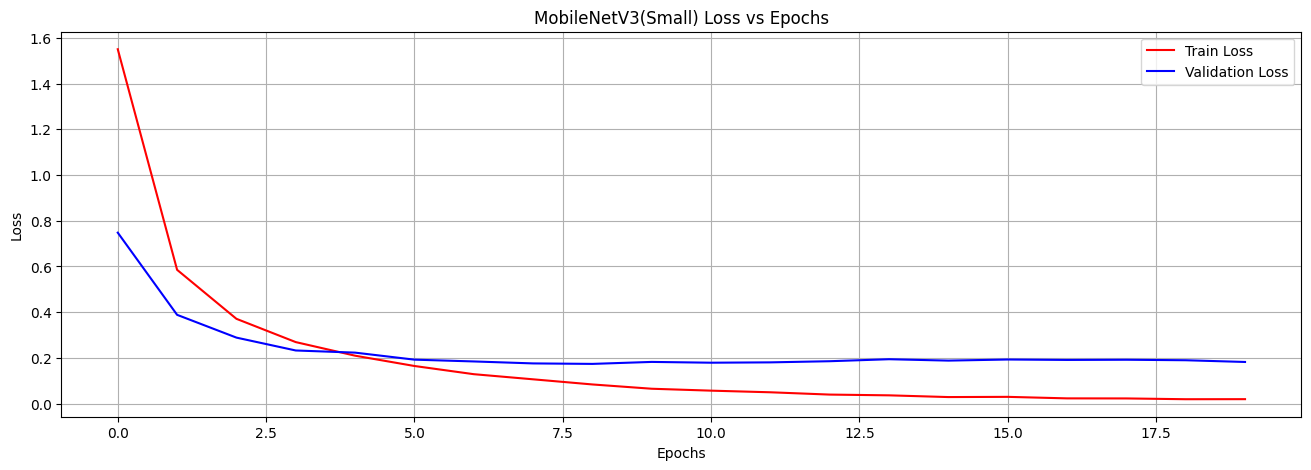

In [18]:
# --- INSTANTIATE / LOAD MODEL ---
mobilenet_model = mobilenet_v3_small(weights='DEFAULT')
# get number of in features from source
num_features = mobilenet_model.classifier[3].in_features
# redefine the networks final fully connected layer
mobilenet_model.classifier[3] = nn.Linear(num_features, 200)
# send to gpu
mobilenet_model = mobilenet_model.to(device)

# --- TRAINING ---
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mobilenet_model.parameters(), lr=1e-4)

# initialize training/val loss & accuracy
mobile_train_loss = []
mobile_train_acc = []
mobile_val_loss = []
mobile_val_acc = []

table = PrettyTable()
table.field_names = ['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']

for epoch in range(num_epochs):
    # training loop
    train_epoch_loss, train_epoch_acc = train(mobilenet_model, device, train_dl, optimizer, loss_fn)
    mobile_train_loss.append(train_epoch_loss)
    mobile_train_acc.append(train_epoch_acc)
    # validation loop
    val_epoch_loss, val_epoch_acc = validate(mobilenet_model, device, val_dl, loss_fn)
    mobile_val_loss.append(val_epoch_loss)
    mobile_val_acc.append(val_epoch_acc)
    # store epoch results in prettytable row
    row = [
        round(epoch+1, 4),  # epoch is an integer, so no need to convert
        round(train_epoch_loss.item(), 4) if isinstance(train_epoch_loss, torch.Tensor) else round(train_epoch_loss, 4),
        round(val_epoch_loss.item(), 4) if isinstance(val_epoch_loss, torch.Tensor) else round(val_epoch_loss, 4),
        round(train_epoch_acc.item(), 4) if isinstance(train_epoch_acc, torch.Tensor) else round(train_epoch_acc, 4),
        round(val_epoch_acc.item(), 4) if isinstance(val_epoch_acc, torch.Tensor) else round(val_epoch_acc, 4)
    ]
    table.add_rows([row])
print(table)

# --- RESULTS VISUALIZATION ---
fig, ax = plt.subplots(1, 1, figsize=(16, 5))  

ax.plot(mobile_train_loss, label='Train Loss', color='red')
ax.plot(mobile_val_loss, label='Validation Loss', color='blue')

ax.set_title('MobileNetV3(Small) Loss vs Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

+-------+---------------+-----------------+-------------------+---------------------+
| Epoch | Training Loss | Validation Loss | Training Accuracy | Validation Accuracy |
+-------+---------------+-----------------+-------------------+---------------------+
|   1   |     1.0725    |      0.2999     |      68.7313      |         90.1        |
|   2   |     0.2733    |      0.1788     |      91.2969      |         94.5        |
|   3   |     0.1505    |      0.1331     |      95.0688      |        95.825       |
|   4   |     0.0961    |      0.1164     |      96.7688      |         96.2        |
|   5   |     0.0652    |      0.0993     |       97.875      |        96.975       |
|   6   |     0.0459    |      0.1011     |      98.4438      |         97.3        |
|   7   |     0.034     |      0.0992     |        98.9       |         97.3        |
|   8   |     0.0273    |      0.0979     |      99.1031      |        97.35        |
|   9   |     0.0237    |      0.0966     |      99.26

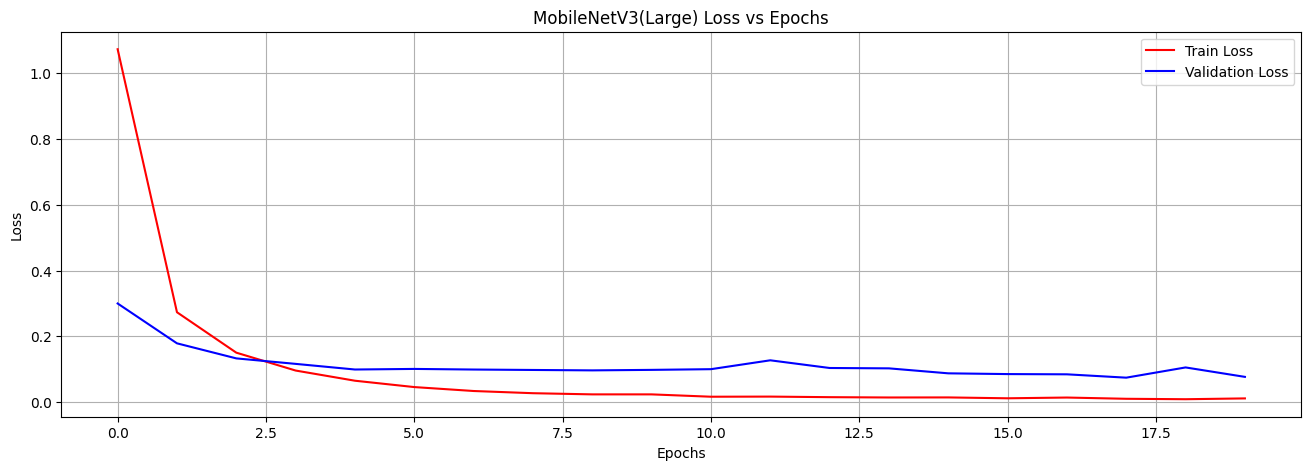

In [21]:
# --- INSTANTIATE / LOAD MODEL ---
mobilenet_model_l = mobilenet_v3_large(weights='DEFAULT')
# get number of in features from source
num_features = mobilenet_model_l.classifier[3].in_features
# redefine the networks final fully connected layer
mobilenet_model_l.classifier[3] = nn.Linear(num_features, 200)
# send to gpu
mobilenet_model_l = mobilenet_model_l.to(device)

# --- TRAINING ---
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mobilenet_model_l.parameters(), lr=1e-4)

# initialize training/val loss & accuracy
mobile_l_train_loss = []
mobile_l_train_acc = []
mobile_l_val_loss = []
mobile_l_val_acc = []

table = PrettyTable()
table.field_names = ['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy']

for epoch in range(num_epochs):
    # training loop
    train_epoch_loss, train_epoch_acc = train(mobilenet_model_l, device, train_dl, optimizer, loss_fn)
    mobile_l_train_loss.append(train_epoch_loss)
    mobile_l_train_acc.append(train_epoch_acc)
    # validation loop
    val_epoch_loss, val_epoch_acc = validate(mobilenet_model_l, device, val_dl, loss_fn)
    mobile_l_val_loss.append(val_epoch_loss)
    mobile_l_val_acc.append(val_epoch_acc)
    # store epoch results in prettytable row
    row = [
        round(epoch+1, 4),  # epoch is an integer, so no need to convert
        round(train_epoch_loss.item(), 4) if isinstance(train_epoch_loss, torch.Tensor) else round(train_epoch_loss, 4),
        round(val_epoch_loss.item(), 4) if isinstance(val_epoch_loss, torch.Tensor) else round(val_epoch_loss, 4),
        round(train_epoch_acc.item(), 4) if isinstance(train_epoch_acc, torch.Tensor) else round(train_epoch_acc, 4),
        round(val_epoch_acc.item(), 4) if isinstance(val_epoch_acc, torch.Tensor) else round(val_epoch_acc, 4)
    ]
    table.add_rows([row])
print(table)

# --- RESULTS VISUALIZATION ---
fig, ax = plt.subplots(1, 1, figsize=(16, 5))  

ax.plot(mobile_l_train_loss, label='Train Loss', color='red')
ax.plot(mobile_l_val_loss, label='Validation Loss', color='blue')

ax.set_title('MobileNetV3(Large) Loss vs Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

In [16]:
resnet_model = resnet50(weights='DEFAULT')
# get number of in_features from source
num_features = resnet_model.fc.in_features
# redefine the networks final fully connected layer
resnet_model.fc = nn.Linear(num_features, num_classes)
# send to gpu
resnet_model = resnet_model.to(device)


res_loss_fn = nn.CrossEntropyLoss()
res_optimizer = torch.optim.Adam(params=resnet_model.parameters(), lr = 1e-5)

# initialize training loss
res_training_loss = []

for epoch in range(num_epochs):
    start_time = time.time()
    for i, (b_x, b_y) in enumerate(train_dataloader):
        # load data to gpu
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        
        y_pred = resnet_model(b_x)
        loss = res_loss_fn(y_pred, b_y)
        
        res_optimizer.zero_grad()
        loss.backward()
        res_optimizer.step()
        
        if i % 5000 == 0:
            res_training_loss.append(loss.item())
            print(f"Epoch: {epoch+1}/{num_epochs} --- Training Loss: {loss.item():.4f}")
            
res_train_time = time.time() - start_time

Epoch: 1/20 --- Training Loss: 2.3592
Epoch: 2/20 --- Training Loss: 0.8607
Epoch: 3/20 --- Training Loss: 0.4986
Epoch: 4/20 --- Training Loss: 0.0289
Epoch: 5/20 --- Training Loss: 0.0449
Epoch: 6/20 --- Training Loss: 0.0352
Epoch: 7/20 --- Training Loss: 0.0332
Epoch: 8/20 --- Training Loss: 0.0174
Epoch: 9/20 --- Training Loss: 0.0095
Epoch: 10/20 --- Training Loss: 0.0362
Epoch: 11/20 --- Training Loss: 0.0145
Epoch: 12/20 --- Training Loss: 0.0052
Epoch: 13/20 --- Training Loss: 0.0057
Epoch: 14/20 --- Training Loss: 0.0039
Epoch: 15/20 --- Training Loss: 0.0046
Epoch: 16/20 --- Training Loss: 0.0252
Epoch: 17/20 --- Training Loss: 0.0006
Epoch: 18/20 --- Training Loss: 0.0259
Epoch: 19/20 --- Training Loss: 0.0056
Epoch: 20/20 --- Training Loss: 0.0055


In [17]:
densenet_model = densenet121(weights='DEFAULT')
# get number of in features from source
num_features = densenet_model.classifier.in_features
# redefine the networks final fully connected layer
densenet_model.classifier = nn.Linear(num_features, num_classes)
# send to gpu
densenet_model = densenet_model.to(device)


dense_loss_fn = nn.CrossEntropyLoss()
dense_optimizer = torch.optim.Adam(params=densenet_model.parameters(), lr = 1e-5)

# initialize training loss
dense_training_loss = []


for epoch in range(num_epochs):
    start_time = time.time()
    for i, (b_x, b_y) in enumerate(train_dataloader):
        # load data to gpu
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        
        y_pred = densenet_model(b_x)
        loss = dense_loss_fn(y_pred, b_y)
        
        dense_optimizer.zero_grad()
        loss.backward()
        dense_optimizer.step()
        
        if i % 5000 == 0:
            dense_training_loss.append(loss.item())
            print(f"Epoch: {epoch+1}/{num_epochs} --- Training Loss: {loss.item():.4f}")
            
dense_train_time = time.time() - start_time

Epoch: 1/20 --- Training Loss: 2.6472
Epoch: 2/20 --- Training Loss: 0.7636
Epoch: 3/20 --- Training Loss: 0.2662
Epoch: 4/20 --- Training Loss: 0.1237
Epoch: 5/20 --- Training Loss: 0.1806
Epoch: 6/20 --- Training Loss: 0.0901
Epoch: 7/20 --- Training Loss: 0.0606
Epoch: 8/20 --- Training Loss: 0.0174
Epoch: 9/20 --- Training Loss: 0.0143
Epoch: 10/20 --- Training Loss: 0.0121
Epoch: 11/20 --- Training Loss: 0.0154
Epoch: 12/20 --- Training Loss: 0.0244
Epoch: 13/20 --- Training Loss: 0.0020
Epoch: 14/20 --- Training Loss: 0.0031
Epoch: 15/20 --- Training Loss: 0.0057
Epoch: 16/20 --- Training Loss: 0.0031
Epoch: 17/20 --- Training Loss: 0.0059
Epoch: 18/20 --- Training Loss: 0.0009
Epoch: 19/20 --- Training Loss: 0.0015
Epoch: 20/20 --- Training Loss: 0.0160


In [25]:
# custom accuracy computation, optionally displays predictions
def validate(model, data, display_pred = False):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        labels = labels.to(device)
        
        model.eval()
        x = model(images)
        value, pred = torch.max(x, 1)
        
        total += x.size(0)
        correct += torch.sum(pred == labels)
        
        if i % 1000 == 0 & display_pred == True:
            print(f"Pred: {x} / True: {labels}")
    return correct / total

In [22]:
def confusion_plot(model, data):
    y_true = []
    y_pred = []
    for i, (images, labels) in enumerate(data):

        model.eval()
        x = model(images)
        value, pred = torch.max(x, 1)
        
        y_pred += pred
        y_true += labels

    confusion_df = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                                index = [j for j in range(10)],
                                columns = [j for j in range(10)]
                               )
  
    plt.figure(figsize = (10,7))
    sns.heatmap(confusion_df, annot=True)
    plt.show()

In [28]:
print(f"SqueezeNet test accuracy: {validate(squeezenet_model.to(device), test_dataloader).item():.4f}")
print(f"MobileNetV3 test accuracy: {validate(mobilenet_model.to(device), test_dataloader).item():.4f}")
print(f"ResNet50 test accuracy: {validate(resnet_model.to(device), test_dataloader).item():.4f}")
print(f"DenseNet121 test accuracy: {validate(densenet_model.to(device), test_dataloader).item():.4f}")

SqueezeNet test accuracy: 0.9274
MobileNetV3 test accuracy: 0.9664
ResNet50 test accuracy: 0.9824
DenseNet121 test accuracy: 0.9860


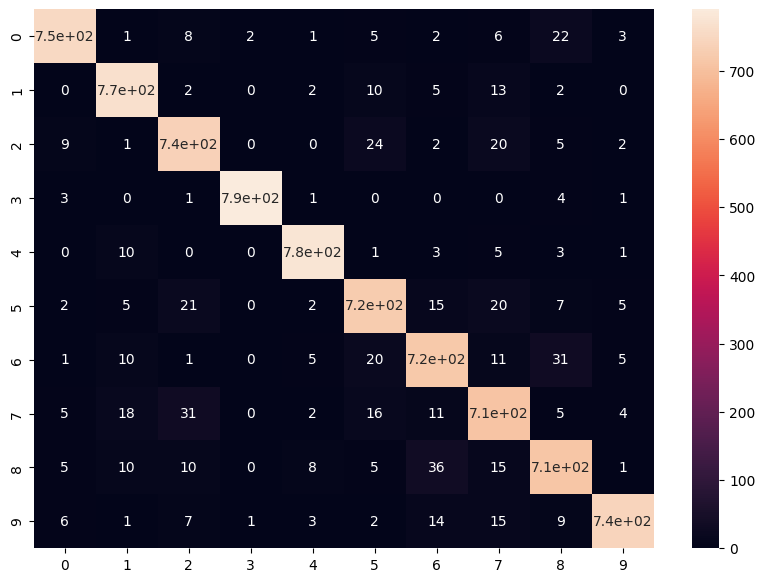

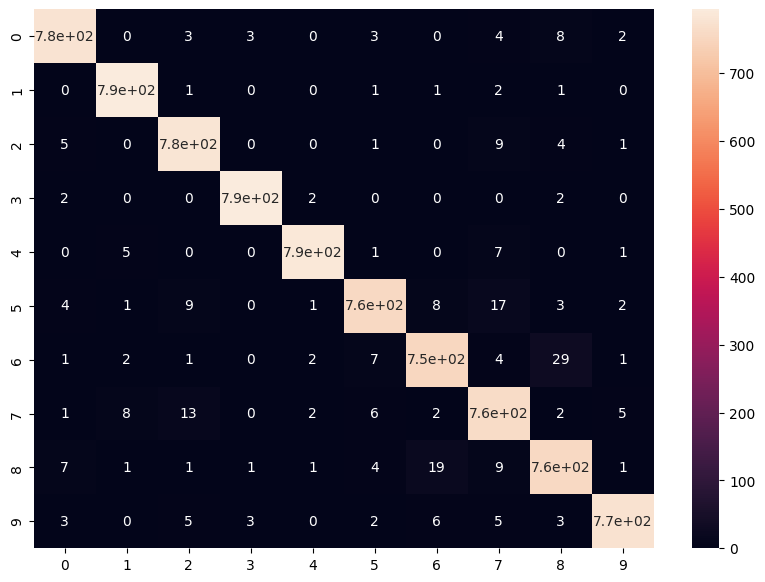

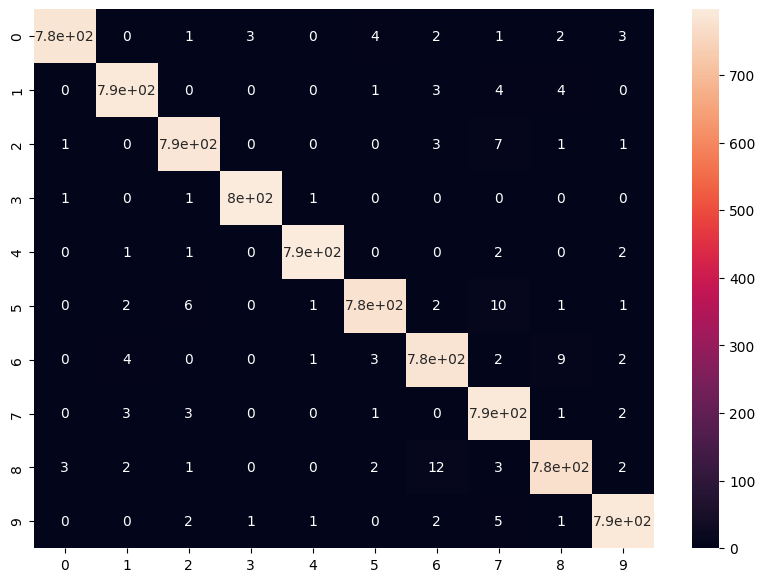

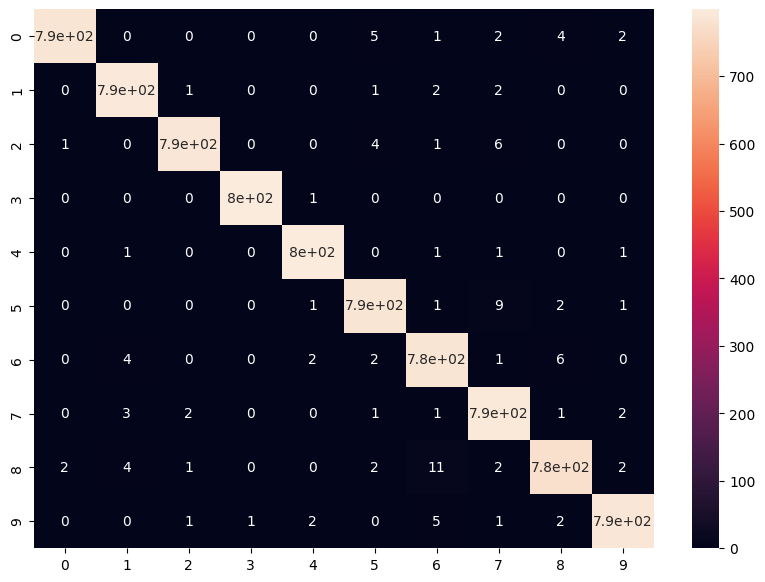

In [24]:
confusion_plot(squeezenet_model.to('cpu'), test_dataloader)
confusion_plot(mobilenet_model.to('cpu'), test_dataloader)
confusion_plot(resnet_model.to('cpu'), test_dataloader)
confusion_plot(densenet_model.to('cpu'), test_dataloader)

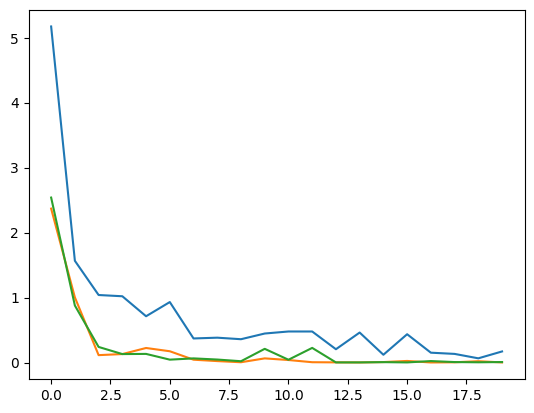

In [ ]:
# plt.plot(squeeze_training_loss)
# plt.plot(res_training_loss)
# plt.plot(dense_training_loss)